## Counterfactual Inference on Synthetic Toy Data
Here we try to recreate the experiment in Section 4.2 of [Louizos, Christos, et al. 2017](http://papers.nips.cc/paper/7223-causal-effect-inference-with-deep-latent-variable-models.pdf)

Data point $X$ is assumed to be a mixture of gaussians, with hidden variable $Z$ determining the mixture components. The data of generated in the following way:

$z_i \sim Bern(0.5)$

$x_i|z_i \sim \mathcal{N} (z_i, \sigma_{z_1}^2 z_i + \sigma_{z_0}^2 (1 - z_i))$

$t_i|z_i \sim Bern(0.75 z_i + 0.25(1 - z_i))$

$y_i|t_i, z_i \sim Bern(Sigmoid(3(z_i + 2(2t_i - 1))))$

where $\sigma_{z_0}=3$ and $\sigma_{z_1}=5$


## Tentative Results

| Model   | Num Samples | PEHE   | Abs ATE Err.     |
| ------- | ----------- | ------ | ---------------- |
| Dumb    | 1000        | 0.0290 | 0.0270           |
|         | 3000        | 0.0253 | 0.0253           |
|         | 5000        | 0.0232 | 0.0232           |
|         | 10000       | 0.0278 | 0.0278           |
|         |             |        |                  |
| Twin RF | 1000        | 0.9800 | 0.9700           |
|         | 3000        | 0.9800 | 0.9800           |
|         | 5000        | 0.9730 | 0.9730           |
|         | 10000       | 0.9745 | 0.9745           |
|         |             |        |                  |
| TARNet  | 1000        | 0.0450 | 0.0350           |
|         | 3000        | 0.0250 | 0.0250           |
|         | 5000        | 0.0240 | 0.0240           |
|         | 10000       | 0.0240 | 0.0240           |
|         |             |        |                  |
| CEVAE   | 1000        | 0.4750 | 0.4700 (0.0387?) |
|         | 3000        | 0.9333 | 0.9300           |
|         | 5000        | 0.7230 | 0.7150           |
|         | 10000       | 0.1003 | 0.0848           |

Note:
- CEVAE and TARNet were trained for 20 epochs
- TARNet model does not have MMD regularization
- Current models have not been tuned properly nor have they been regularized (DO, etc)
- Validation results != Test results



In [1]:
#!pip install pytorch-ignite

In [2]:
#!conda install scikit-learn

In [26]:
%load_ext autoreload

import os
import math, random
import scipy.stats as stats
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_style('whitegrid')

import torch
from torch.optim import Adam, SGD
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from ignite.engine import Engine, Events
from ignite.contrib.handlers import ProgressBar
import ignite.metrics as ignite_metrics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Fix constants and helper methods
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def rounded_sigmoid(logits: torch.Tensor) -> torch.Tensor:
    return torch.round(torch.sigmoid(logits))


def seed_everything(seed: int) -> None:
    "seeding function for reproducibility"
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
NUM_SAMPLES = 1000
P0 = 0.5
SIG_Z0 = 3
SIG_Z1 = 5  
T_TAU_Z0 = 0.75
T_TAU_Z1 = 0.25
# visualize tau (represents the prob of getting y = 1, 
# i.e y = Bern(tau))
TAU = np.zeros((2, 2))
for z in range(2):
    for t in range(2):
        # TAU[z, t] = sigmoid(3 * (z + 2 * (2 * t - 1))) # original
        TAU[z, t] = sigmoid(1.5 * (z + 1.3 * (2 * t - 1)))

PLOT_STYLE = 'ggplot'      

seed_everything(123)

In [5]:
def prepare_data_df(num_samples, sig_z0, sig_z1) -> pd.DataFrame:
    # First sample from Bernoulli for z_i
    z_dist = dist.Bernoulli(probs=P0)
    zs = z_dist.sample((NUM_SAMPLES, ))
    print(f"Sanity checking z_dist:\n{zs.mean():.3f}")
    df = pd.DataFrame(zs.numpy(), columns=['z'])

    # Next sampling t_i and x_i from z_i
    x_s, t_s = [], []
    for idx in df.index:
        z_i = df.loc[idx, 'z']
        x_var = (np.square(sig_z1) * z_i + np.square(sig_z0) * (1 - z_i))
        x_sample = dist.Normal(
            loc=z_i, 
            scale=np.sqrt(x_var)
        ).sample()
        x_s.append(x_sample.item())
        
        t_sample = dist.Bernoulli(T_TAU_Z0 * z_i + T_TAU_Z1 * (1 - z_i)).sample()
        t_s.append(t_sample.item())

    df['X'] = x_s
    df['t'] = t_s

    # Lastly sample y_i conditioned on z_i and t_i
    y0s, y1s = [], []
    for idx in df.index:
        z_i = df.loc[idx, 'z']
        t_i = df.loc[idx, 't']def prepare_data_df(num_samples, sig_z0, sig_z1) -> pd.DataFrame:
    # First sample from Bernoulli for z_i
    z_dist = dist.Bernoulli(probs=P0)
    zs = z_dist.sample((NUM_SAMPLES, ))
    print(f"Sanity checking z_dist:\n{zs.mean():.3f}")
    df = pd.DataFrame(zs.numpy(), columns=['z'])

    # Next sampling t_i and x_i from z_i
    x_s, t_s = [], []
    for idx in df.index:
        z_i = df.loc[idx, 'z']
        x_var = (np.square(sig_z1) * z_i + np.square(sig_z0) * (1 - z_i))
        x_sample = dist.Normal(
            loc=z_i, 
            scale=np.sqrt(x_var)
        ).sample()
        x_s.append(x_sample.item())
        
        t_sample = dist.Bernoulli(T_TAU_Z0 * z_i + T_TAU_Z1 * (1 - z_i)).sample()
        t_s.append(t_sample.item())

    df['X'] = x_s
    df['t'] = t_s

    # Lastly sample y_i conditioned on z_i and t_i
    y0s, y1s = [], []
    for idx in df.index:
        z_i = df.loc[idx, 'z']
        t_i = df.loc[idx, 't']

        # outcome when t = 0
        y0_sample = dist.Bernoulli(TAU[int(z_i), 0]).sample()
        y0s.append(y0_sample.item())

        # outcome when t = 1
        y1_sample = dist.Bernoulli(TAU[int(z_i), 1]).sample()
        y1s.append(y1_sample.item())
        
    df['y0'] = y0s # untreated outcome for given z
    df['y1'] = y1s # treated outcome for given z
    df['yf'] =  np.where(df['t'] == 0, df['y0'], df['y1'])

    print(f"t value  counts:\n{df['t'].value_counts()}")
    print(f"y0 value counts:\n{df['y0'].value_counts()}")
    print(f"y1 value  counts:\n{df['y1'].value_counts()}")

    return df

def visualize_data(df: pd.DataFrame) -> None:
    # Visualize the generated data
    with plt.style.context(PLOT_STYLE):
        kwargs = dict(bins=50, )
        fig, ax = plt.subplots(3, 2, figsize=(10, 15))
        sns.distplot(df.query("z == 0")['X'], ax=ax[0, 0], label='z = 0', **kwargs)
        sns.distplot(df.query("z == 1")['X'], ax=ax[0, 0], label='z = 1', **kwargs)
        ax[0, 0].axvline(df.query("z == 0")['X'].mean(), color="gray", linestyle="dotted")
        ax[0, 0].axvline(df.query("z == 1")['X'].mean(), color="gray", linestyle="dotted")
        ax[0, 0].set_xlabel('X')
        ax[0, 0].set_title('p(X|z)')
        ax[0, 0].legend()


        sns.scatterplot(x=df.query("z == 0 & t == 0")['X'], y=TAU[0, 0], ax=ax[0, 1], label='z = 0, t = 0')
        sns.scatterplot(x=df.query("z == 1 & t == 0")['X'], y=TAU[1, 0], ax=ax[0, 1], label='z = 1, t = 0')
        sns.scatterplot(x=df.query("z == 0 & t == 1")['X'], y=TAU[0, 1], ax=ax[0, 1], label='z = 0, t = 1')
        sns.scatterplot(x=df.query("z == 1 & t == 1")['X'], y=TAU[1, 1], ax=ax[0, 1], label='z = 1, t = 1')
        ax[0, 1].set_xlabel('X')
        ax[0, 1].set_ylabel('prob')
        ax[0, 1].set_title('p(y=1|z, t)')
        ax[0, 1].legend()

        sns.distplot(df.query("z == 0 & t == 0")['X'], ax=ax[1, 0], label='z = 0', **kwargs)
        sns.distplot(df.query("z == 1 & t == 0")['X'], ax=ax[1, 0], label='z = 1', **kwargs)
        ax[1, 0].axvline(df.query("z == 0 & t == 0")['X'].mean(), color="gray", linestyle="dotted")
        ax[1, 0].axvline(df.query("z == 1 & t == 0")['X'].mean(), color="gray", linestyle="dotted")
        ax[1, 0].set_xlabel('X')
        ax[1, 0].set_title('Untreated p(X|z)')
        ax[1, 0].legend()

        sns.distplot(df.query("z == 0 & t == 1")['X'], ax=ax[1, 1], label='z = 0', **kwargs)
        sns.distplot(df.query("z == 1 & t == 1")['X'], ax=ax[1, 1], label='z = 1', **kwargs)
        ax[1, 1].axvline(df.query("z == 0 & t == 1")['X'].mean(), color="gray", linestyle="dotted")
        ax[1, 1].axvline(df.query("z == 1 & t == 1")['X'].mean(), color="gray", linestyle="dotted")
        ax[1, 1].set_xlabel('X')
        ax[1, 1].set_title('Treated p(X|z)')
        ax[1, 1].legend()
        ;

        sns.scatterplot(x=df.query("z == 0 & t == 0")['X'], y=0.25, ax=ax[2, 0], label='z = 0, t = 0', alpha=0.7)
        sns.scatterplot(x=df.query("z == 0 & t == 1")['X'], y=0.25, ax=ax[2, 0], label='z = 0, t = 1', alpha=0.7)
        sns.scatterplot(x=df.query("z == 1 & t == 0")['X'], y=0.75, ax=ax[2, 0], label='z = 1, t = 0', alpha=0.7)
        sns.scatterplot(x=df.query("z == 1 & t == 1")['X'], y=0.75, ax=ax[2, 0], label='z = 1, t = 1', alpha=0.7)
        ax[2, 0].set_xlabel('X')
        ax[2, 0].set_title('Propensity p(t|z)')
        ax[2, 0].legend();


        sns.distplot(df.query("t == 0")['X'], ax=ax[2, 1], label='t = 0')
        sns.distplot(df.query("t == 1")['X'], ax=ax[2, 1], label='t = 1')
        ax[2, 1].set_xlabel('X')
        ax[2, 1].set_title('Propensity p(t|X)')
        ax[2, 1].legend();        

        return

def visualize_pdfs(P0, T_TAU_Z0, T_TAU_Z1, SIG_Z0, SIG_Z1):
    x_grid = np.linspace(-15, 15, 100)
    norm_z0 = stats.norm(0, SIG_Z0) # cluster 1
    norm_z1 = stats.norm(1, SIG_Z1) # cluster 2

    with plt.style.context(PLOT_STYLE):
        fig, ax = plt.subplots(2, 2, figsize=(10, 10))
        # p(z=1|X) ~ p(x|z=1) p(z=1)
        
        aux_z0 = P0 * norm_z1.pdf(x_grid)
        aux_z1 = (1 - P0) * norm_z0.pdf(x_grid)
        curve = aux_z0 / (aux_z0 + aux_z1)
        sns.lineplot(x_grid, curve, ax=ax[0, 0])
        ax[0, 0].set_xlabel('X')
        ax[0, 0].set_ylabel('prob')
        ax[0, 0].set_title('p(z=1|X)')

        # p(z=1|X, t) ~ p(X|z=1) p(t|z=1) p(z=1)
        aux_z0 = P0 * T_TAU_Z0 * norm_z1.pdf(x_grid)
        aux_z1 = (1 - P0) * T_TAU_Z1 * norm_z0.pdf(x_grid)
        curve = aux_z0 / (aux_z0 + aux_z1)
        sns.lineplot(x_grid, curve, ax=ax[0, 1], label='t = 1')

        aux_z0 = P0 * (1 - T_TAU_Z0) * norm_z1.pdf(x_grid)
        aux_z1 = (1 - P0) * (1 - T_TAU_Z1) * norm_z0.pdf(x_grid)
        curve = aux_z0 / (aux_z0 + aux_z1)
        sns.lineplot(x_grid, curve, ax=ax[0, 1], label='t = 0')

        ax[0, 1].set_xlabel('X')
        ax[0, 1].set_ylabel('prob')
        ax[0, 1].set_title('p(z=1|X, t)')

        # p(y=1|X, t) = 
        #   p(y=1|t, z=1) p(z=1|X, t) +
        #   p(y=1|t, z=0) p(z=0|X, t) 
        # = 
        #   p(y=1|t, z=1) p(z=1|X, t) + 
        #   p(y=1|t, z=0) (1 - p(z=1|X, t))

        aux_z0 = P0 * T_TAU_Z0 * norm_z1.pdf(x_grid)
        aux_z1 = (1 - P0) * T_TAU_Z1 * norm_z0.pdf(x_grid)
        pos_z = aux_z0 / (aux_z0 + aux_z1) # p(z=1|x, t=1)
        # TAU coords = 
        # z0_t0  z0_t1
        # z1_t0  z1_t1
        curve = TAU[1, 1] * pos_z + TAU[0, 1] * (1 - pos_z)
        sns.lineplot(x_grid, curve, ax=ax[1, 0], label='t = 1')

        aux_z0 = P0 * (1 - T_TAU_Z0) * norm_z1.pdf(x_grid)
        aux_z1 = (1 - P0) * (1 - T_TAU_Z1) * norm_z0.pdf(x_grid)
        pos_z = aux_z0 / (aux_z0 + aux_z1) # p(z=1|x, t=0)
        # TAU coords = 
        # z0_t0  z0_t1
        # z1_t0  z1_t1
        curve = TAU[1, 0] * pos_z + TAU[0, 0] * (1 - pos_z)
        sns.lineplot(x_grid, curve, ax=ax[1, 0], label='t = 0')
        ax[1, 0].set_xlabel('X')
        ax[1, 0].set_ylabel('prob')
        ax[1, 0].set_title('p(y=1|X, t)')

        # p(y|X, do(t)) = 
        #   p(y|X, do(t), z=0) p(z=0|X, do(t)) +
        #   p(y|X, do(t), z=1) p(z=1|X, do(t))
        # =
        #   p(y|X, t, z=0) p(z=0|X, t) +
        #   p(y|X, t, z=1) p(z=1|X, t)
        aux_z0 = P0 * norm_z0.pdf(x_grid)
        aux_z1 = (1 - P0) * norm_z1.pdf(x_grid)
        pos_z0 = aux_z0 / (aux_z0 + aux_z1) # p(z=0|X)
        # TAU coords = 
        # z0_t0  z0_t1
        # z1_t0  z1_t1
        curve = TAU[0, 0] * pos_z0 + TAU[1, 0] * (1 - pos_z0)
        sns.lineplot(x_grid, curve, ax=ax[1, 1], label='do(t = 0)')

        curve = TAU[0, 1] * pos_z0 + TAU[1, 1] * (1 - pos_z0)
        sns.lineplot(x_grid, curve, ax=ax[1, 1], label='do(t = 1)')
        ax[1, 1].set_xlabel('X')
        ax[1, 1].set_ylabel('prob')
        ax[1, 1].set_title('p(y=1|X, do(t))')


        # outcome when t = 0
        y0_sample = dist.Bernoulli(TAU[int(z_i), 0]).sample()
        y0s.append(y0_sample.item())

        # outcome when t = 1
        y1_sample = dist.Bernoulli(TAU[int(z_i), 1]).sample()
        y1s.append(y1_sample.item())
        
    df['y0'] = y0s # untreated outcome for given z
    df['y1'] = y1s # treated outcome for given z
    df['yf'] =  np.where(df['t'] == 0, df['y0'], df['y1'])

    print(f"t value  counts:\n{df['t'].value_counts()}")
    print(f"y0 value counts:\n{df['y0'].value_counts()}")
    print(f"y1 value  counts:\n{df['y1'].value_counts()}")

    return df

def visualize_data(df: pd.DataFrame) -> None:
    # Visualize the generated data
    with plt.style.context(PLOT_STYLE):
        kwargs = dict(bins=50, )
        fig, ax = plt.subplots(3, 2, figsize=(10, 15))
        sns.distplot(df.query("z == 0")['X'], ax=ax[0, 0], label='z = 0', **kwargs)
        sns.distplot(df.query("z == 1")['X'], ax=ax[0, 0], label='z = 1', **kwargs)
        ax[0, 0].axvline(df.query("z == 0")['X'].mean(), color="gray", linestyle="dotted")
        ax[0, 0].axvline(df.query("z == 1")['X'].mean(), color="gray", linestyle="dotted")
        ax[0, 0].set_xlabel('X')
        ax[0, 0].set_title('p(X|z)')
        ax[0, 0].legend()


        sns.scatterplot(x=df.query("z == 0 & t == 0")['X'], y=TAU[0, 0], ax=ax[0, 1], label='z = 0, t = 0')
        sns.scatterplot(x=df.query("z == 1 & t == 0")['X'], y=TAU[1, 0], ax=ax[0, 1], label='z = 1, t = 0')
        sns.scatterplot(x=df.query("z == 0 & t == 1")['X'], y=TAU[0, 1], ax=ax[0, 1], label='z = 0, t = 1')
        sns.scatterplot(x=df.query("z == 1 & t == 1")['X'], y=TAU[1, 1], ax=ax[0, 1], label='z = 1, t = 1')
        ax[0, 1].set_xlabel('X')
        ax[0, 1].set_ylabel('prob')
        ax[0, 1].set_title('p(y=1|z, t)')
        ax[0, 1].legend()

        sns.distplot(df.query("z == 0 & t == 0")['X'], ax=ax[1, 0], label='z = 0', **kwargs)
        sns.distplot(df.query("z == 1 & t == 0")['X'], ax=ax[1, 0], label='z = 1', **kwargs)
        ax[1, 0].axvline(df.query("z == 0 & t == 0")['X'].mean(), color="gray", linestyle="dotted")
        ax[1, 0].axvline(df.query("z == 1 & t == 0")['X'].mean(), color="gray", linestyle="dotted")
        ax[1, 0].set_xlabel('X')
        ax[1, 0].set_title('Untreated p(X|z)')
        ax[1, 0].legend()

        sns.distplot(df.query("z == 0 & t == 1")['X'], ax=ax[1, 1], label='z = 0', **kwargs)
        sns.distplot(df.query("z == 1 & t == 1")['X'], ax=ax[1, 1], label='z = 1', **kwargs)
        ax[1, 1].axvline(df.query("z == 0 & t == 1")['X'].mean(), color="gray", linestyle="dotted")
        ax[1, 1].axvline(df.query("z == 1 & t == 1")['X'].mean(), color="gray", linestyle="dotted")
        ax[1, 1].set_xlabel('X')
        ax[1, 1].set_title('Treated p(X|z)')
        ax[1, 1].legend()
        ;

        sns.scatterplot(x=df.query("z == 0 & t == 0")['X'], y=0.25, ax=ax[2, 0], label='z = 0, t = 0', alpha=0.7)
        sns.scatterplot(x=df.query("z == 0 & t == 1")['X'], y=0.25, ax=ax[2, 0], label='z = 0, t = 1', alpha=0.7)
        sns.scatterplot(x=df.query("z == 1 & t == 0")['X'], y=0.75, ax=ax[2, 0], label='z = 1, t = 0', alpha=0.7)
        sns.scatterplot(x=df.query("z == 1 & t == 1")['X'], y=0.75, ax=ax[2, 0], label='z = 1, t = 1', alpha=0.7)
        ax[2, 0].set_xlabel('X')
        ax[2, 0].set_title('Propensity p(t|z)')
        ax[2, 0].legend();


        sns.distplot(df.query("t == 0")['X'], ax=ax[2, 1], label='t = 0')
        sns.distplot(df.query("t == 1")['X'], ax=ax[2, 1], label='t = 1')
        ax[2, 1].set_xlabel('X')
        ax[2, 1].set_title('Propensity p(t|X)')
        ax[2, 1].legend();        

        return

def visualize_pdfs(P0, T_TAU_Z0, T_TAU_Z1, SIG_Z0, SIG_Z1):
    x_grid = np.linspace(-15, 15, 100)
    norm_z0 = stats.norm(0, SIG_Z0) # cluster 1
    norm_z1 = stats.norm(1, SIG_Z1) # cluster 2

    with plt.style.context(PLOT_STYLE):
        fig, ax = plt.subplots(2, 2, figsize=(10, 10))
        # p(z=1|X) ~ p(x|z=1) p(z=1)
        
        aux_z0 = P0 * norm_z1.pdf(x_grid)
        aux_z1 = (1 - P0) * norm_z0.pdf(x_grid)
        curve = aux_z0 / (aux_z0 + aux_z1)
        sns.lineplot(x_grid, curve, ax=ax[0, 0])
        ax[0, 0].set_xlabel('X')
        ax[0, 0].set_ylabel('prob')
        ax[0, 0].set_title('p(z=1|X)')

        # p(z=1|X, t) ~ p(X|z=1) p(t|z=1) p(z=1)
        aux_z0 = P0 * T_TAU_Z0 * norm_z1.pdf(x_grid)
        aux_z1 = (1 - P0) * T_TAU_Z1 * norm_z0.pdf(x_grid)
        curve = aux_z0 / (aux_z0 + aux_z1)
        sns.lineplot(x_grid, curve, ax=ax[0, 1], label='t = 1')

        aux_z0 = P0 * (1 - T_TAU_Z0) * norm_z1.pdf(x_grid)
        aux_z1 = (1 - P0) * (1 - T_TAU_Z1) * norm_z0.pdf(x_grid)
        curve = aux_z0 / (aux_z0 + aux_z1)
        sns.lineplot(x_grid, curve, ax=ax[0, 1], label='t = 0')

        ax[0, 1].set_xlabel('X')
        ax[0, 1].set_ylabel('prob')
        ax[0, 1].set_title('p(z=1|X, t)')

        # p(y=1|X, t) = 
        #   p(y=1|t, z=1) p(z=1|X, t) +
        #   p(y=1|t, z=0) p(z=0|X, t) 
        # = 
        #   p(y=1|t, z=1) p(z=1|X, t) + 
        #   p(y=1|t, z=0) (1 - p(z=1|X, t))

        aux_z0 = P0 * T_TAU_Z0 * norm_z1.pdf(x_grid)
        aux_z1 = (1 - P0) * T_TAU_Z1 * norm_z0.pdf(x_grid)
        pos_z = aux_z0 / (aux_z0 + aux_z1) # p(z=1|x, t=1)
        # TAU coords = 
        # z0_t0  z0_t1
        # z1_t0  z1_t1
        curve = TAU[1, 1] * pos_z + TAU[0, 1] * (1 - pos_z)
        sns.lineplot(x_grid, curve, ax=ax[1, 0], label='t = 1')

        aux_z0 = P0 * (1 - T_TAU_Z0) * norm_z1.pdf(x_grid)
        aux_z1 = (1 - P0) * (1 - T_TAU_Z1) * norm_z0.pdf(x_grid)
        pos_z = aux_z0 / (aux_z0 + aux_z1) # p(z=1|x, t=0)
        # TAU coords = 
        # z0_t0  z0_t1
        # z1_t0  z1_t1
        curve = TAU[1, 0] * pos_z + TAU[0, 0] * (1 - pos_z)
        sns.lineplot(x_grid, curve, ax=ax[1, 0], label='t = 0')
        ax[1, 0].set_xlabel('X')
        ax[1, 0].set_ylabel('prob')
        ax[1, 0].set_title('p(y=1|X, t)')

        # p(y|X, do(t)) = 
        #   p(y|X, do(t), z=0) p(z=0|X, do(t)) +
        #   p(y|X, do(t), z=1) p(z=1|X, do(t))
        # =
        #   p(y|X, t, z=0) p(z=0|X, t) +
        #   p(y|X, t, z=1) p(z=1|X, t)
        aux_z0 = P0 * norm_z0.pdf(x_grid)
        aux_z1 = (1 - P0) * norm_z1.pdf(x_grid)
        pos_z0 = aux_z0 / (aux_z0 + aux_z1) # p(z=0|X)
        # TAU coords = 
        # z0_t0  z0_t1
        # z1_t0  z1_t1
        curve = TAU[0, 0] * pos_z0 + TAU[1, 0] * (1 - pos_z0)
        sns.lineplot(x_grid, curve, ax=ax[1, 1], label='do(t = 0)')

        curve = TAU[0, 1] * pos_z0 + TAU[1, 1] * (1 - pos_z0)
        sns.lineplot(x_grid, curve, ax=ax[1, 1], label='do(t = 1)')
        ax[1, 1].set_xlabel('X')
        ax[1, 1].set_ylabel('prob')
        ax[1, 1].set_title('p(y=1|X, do(t))')


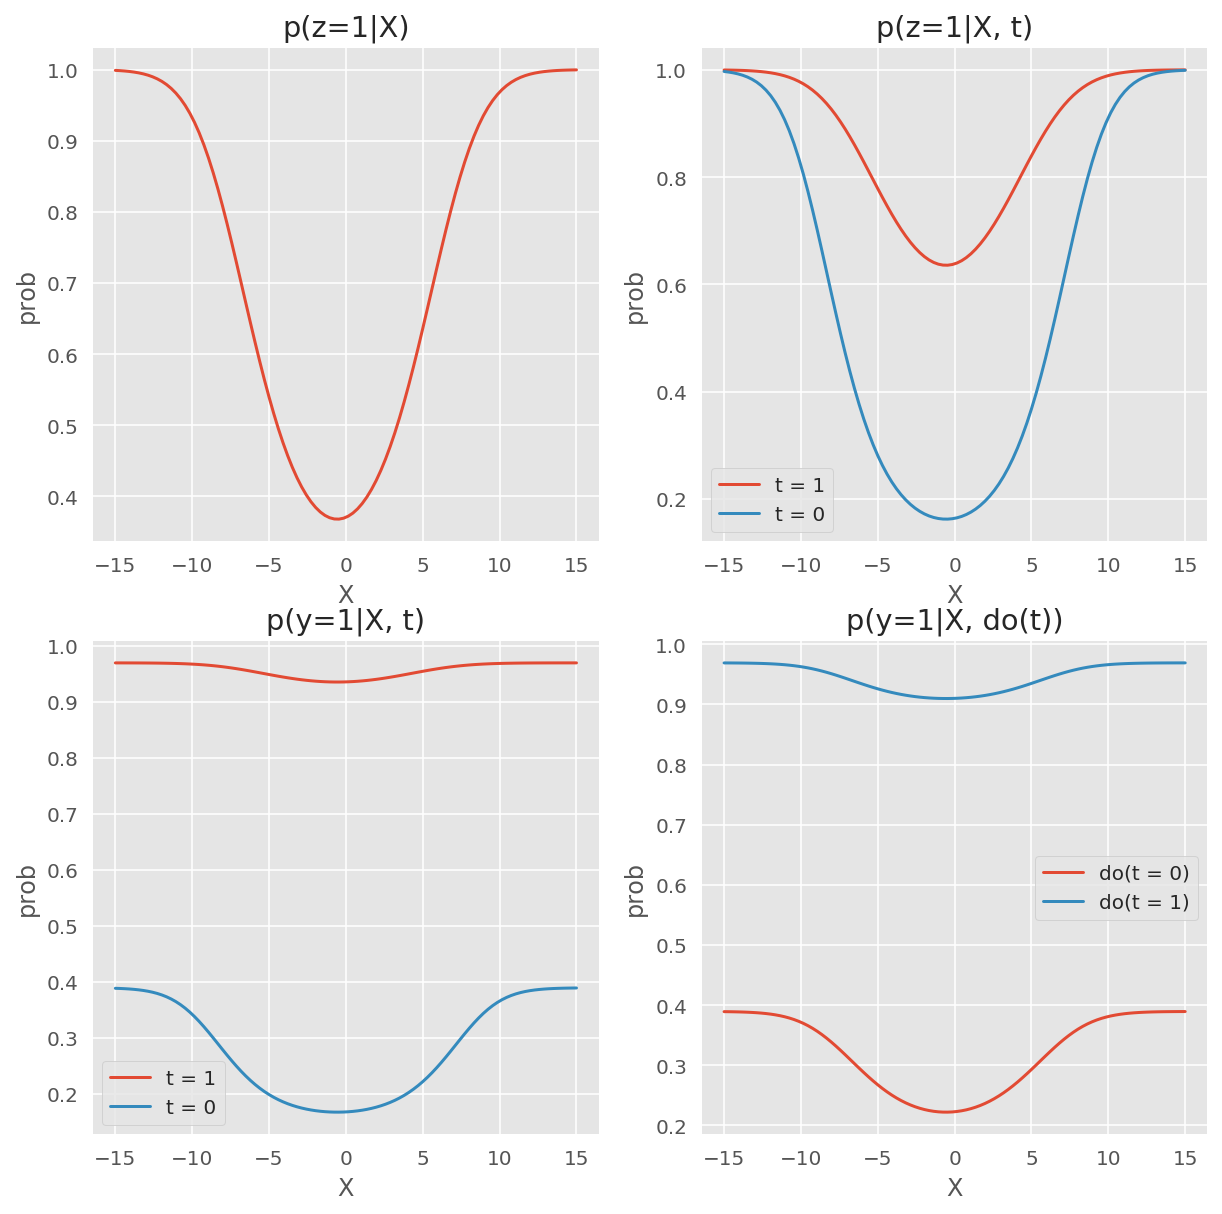

In [6]:
visualize_pdfs(P0, T_TAU_Z0, T_TAU_Z1, SIG_Z0, SIG_Z1)

Sanity checking z_dist:
0.501
t value  counts:
0.0    505
1.0    495
Name: t, dtype: int64
y0 value counts:
0.0    727
1.0    273
Name: y0, dtype: int64
y1 value  counts:
1.0    923
0.0     77
Name: y1, dtype: int64


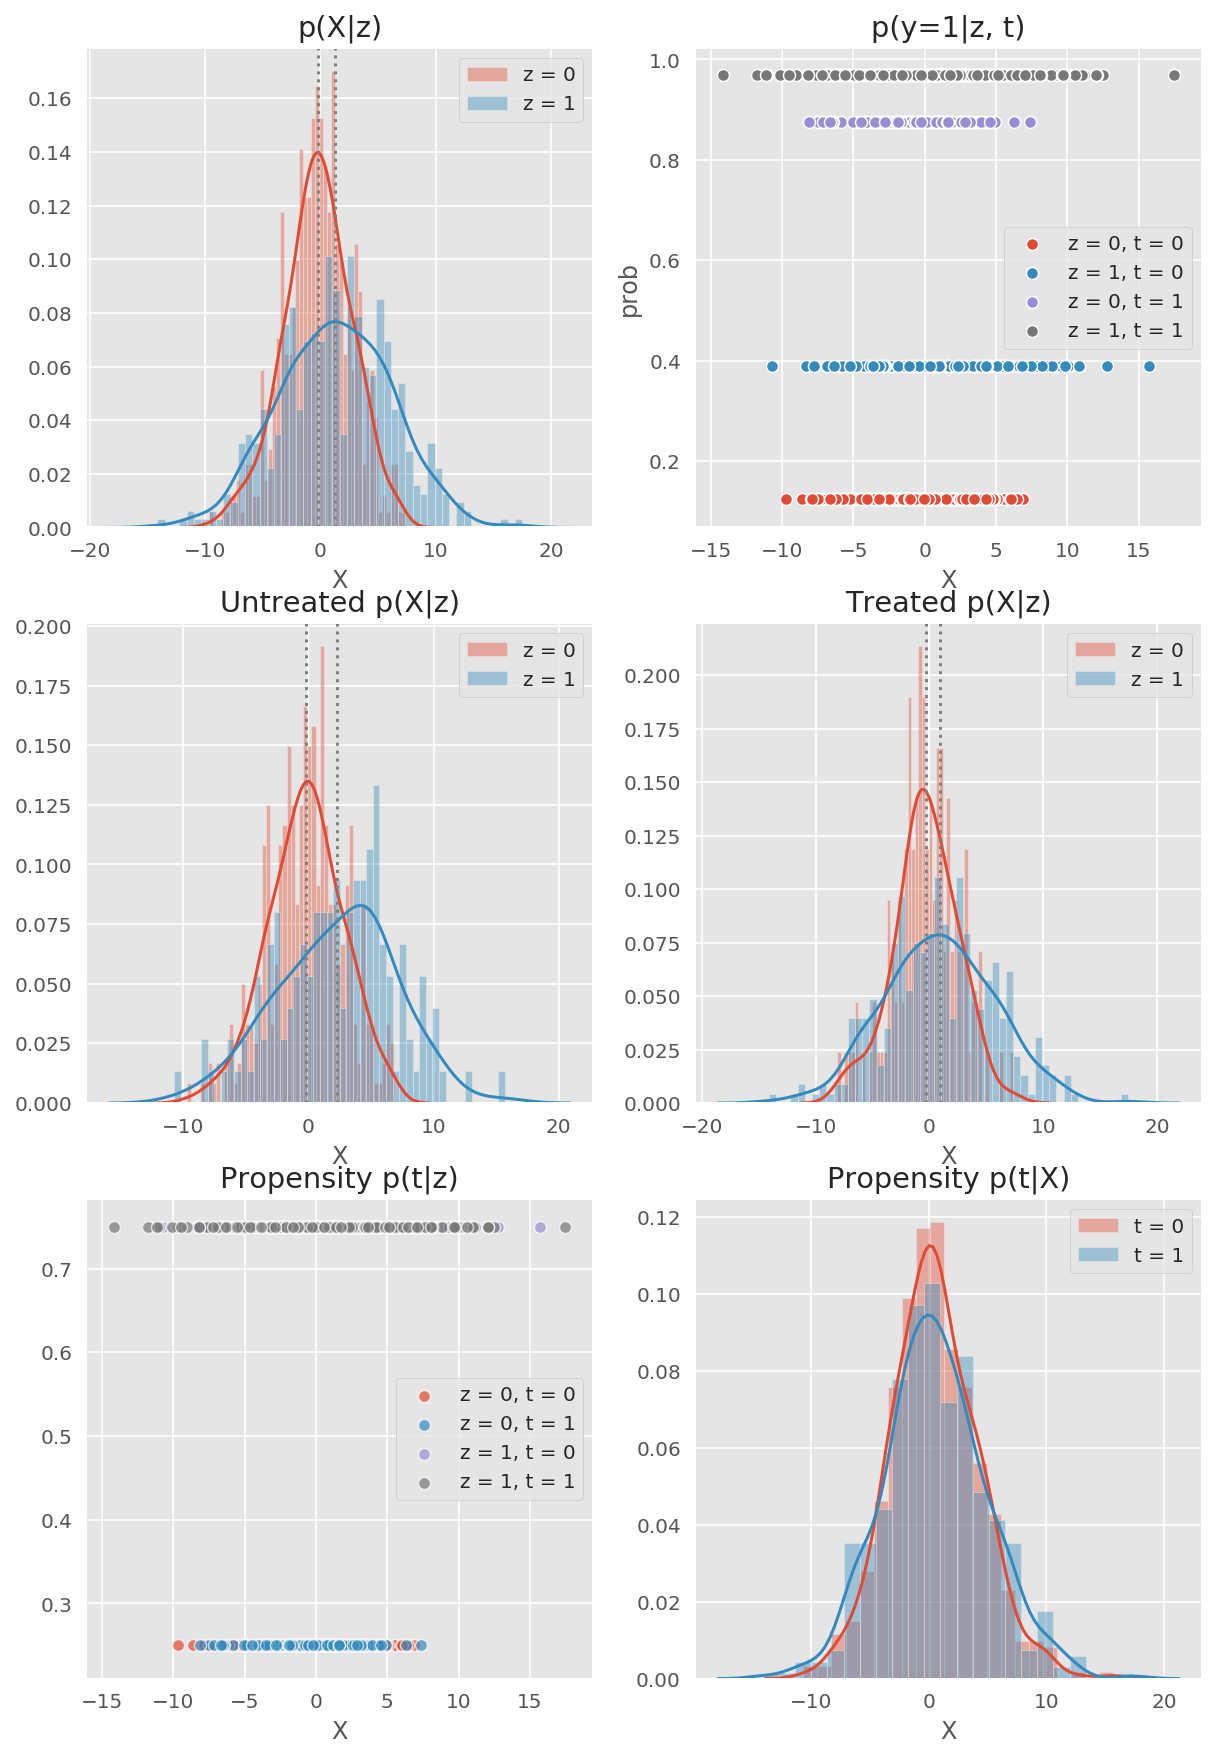

In [7]:
df = prepare_data_df(NUM_SAMPLES, SIG_Z0, SIG_Z1)
visualize_data(df)

In [8]:
# How well does a dumb model do?
print(f"Data size: {df.shape[0]}")
print("y0 value counts:")
print(df.y0.value_counts()/df.shape[0])
print("y1 value counts:")
print(df.y1.value_counts()/df.shape[0])
print("yf value counts:")
print(df.yf.value_counts()/df.shape[0])

# if the model could accurately predict the treatment
# it can then just choose 
# yf = 1 if t = 1 and yf = 0 if t = 0
# what will be the ITE and ATE and PEHE for this model?
y0_pred = np.zeros((df.shape[0],))
y1_pred = np.ones((df.shape[0],))

y0_true = df['y0'].values
y1_true = df['y1'].values

ite_pred = y1_pred - y0_pred
ite_true = y1_true - y0_true

print()
print("Metrics for dumb model with true treatment values:")
print(f"PEHE: {np.mean(np.square(ite_true - ite_pred)):.4f}")
print(f"Abs ATE Err.: {np.abs(np.mean(ite_true) - np.mean(ite_pred)):.4f}")

Data size: 1000
y0 value counts:
0.0    0.727
1.0    0.273
Name: y0, dtype: float64
y1 value counts:
1.0    0.923
0.0    0.077
Name: y1, dtype: float64
yf value counts:
1.0    0.567
0.0    0.433
Name: yf, dtype: float64

Metrics for dumb model with true treatment values:
PEHE: 0.3900
Abs ATE Err.: 0.3500


In [9]:
# Train two RF models for each treatment 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=123)

rf0 = RandomForestClassifier()
rf1 = RandomForestClassifier()

X0_train= df_train.query("t == 0")['X'].values
y0_train = df_train.query("t == 0")['yf'].values
X1_train = df_train.query("t == 1")['X'].values
y1_train = df_train.query("t == 1")['yf'].values
X0_train.shape = (X0_train.size,1)
X1_train.shape = (X1_train.size,1)

X_test = df_test['X'].values
X_test.shape = (X_test.size,1)
y0_test = df_test['y0'].values
y1_test = df_test['y1'].values

rf0.fit(X0_train, y0_train)
rf1.fit(X1_train, y1_train)

y0_pred = rf0.predict(X_test)
y1_pred = rf1.predict(X_test)

ite_pred = y1_pred - y0_pred
ite_true = y1_test - y0_test

print()
print("Metrics for Twin RF Model with true treatment values:")
print(f"PEHE: {np.mean(np.square(ite_true - ite_pred)):.4f}")
print(f"Abs ATE Err.: {np.abs(np.mean(ite_true) - np.mean(ite_pred)):.4f}")


Metrics for Twin RF Model with true treatment values:
PEHE: 0.5450
Abs ATE Err.: 0.1050


In [10]:
# Train two RF models for each treatment 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=123)

rf0 = RandomForestClassifier()
rf1 = RandomForestClassifier()

X0_train= df_train.query("t == 0")['X'].values
X0_train = np.column_stack([X0_train, np.zeros(X0_train.shape[0],)])
y0_train = df_train.query("t == 0")['yf'].values
X1_train = df_train.query("t == 1")['X'].values
X1_train = np.column_stack([X1_train, np.ones(X1_train.shape[0],)])
y1_train = df_train.query("t == 1")['yf'].values

X_test = df_test['X'].values
y0_test = df_test['y0'].values
y1_test = df_test['y1'].values

rf0.fit(X0_train, y0_train)
rf1.fit(X1_train, y1_train)

y0_pred = rf0.predict(np.column_stack([X_test, np.zeros(X_test.shape[0],)]))
y1_pred = rf1.predict(np.column_stack([X_test, np.ones(X_test.shape[0],)]))

ite_pred = y1_pred - y0_pred
ite_true = y1_test - y0_test

print()
print("Metrics for Twin RF Model with true treatment values:")
print(f"PEHE: {np.mean(np.square(ite_true - ite_pred)):.4f}")
print(f"Abs ATE Err.: {np.abs(np.mean(ite_true) - np.mean(ite_pred)):.4f}")


Metrics for Twin RF Model with true treatment values:
PEHE: 0.5450
Abs ATE Err.: 0.1050


In [11]:
df.X.describe()

count    1000.000000
mean        0.526696
std         4.078706
min       -14.130157
25%        -2.080764
50%         0.346386
75%         3.126247
max        17.474087
Name: X, dtype: float64

In [12]:
# Define pytorch datasets and loaders
class ToyDataset(Dataset):
    def __init__(self, data: pd.DataFrame):
        self.length = data.shape[0]
        self.t = data.loc[:, 't'].values
        self.X = data.loc[:, 'X'].values
        self.y0 = data.loc[:, 'y0'].values
        self.y1 = data.loc[:, 'y1'].values
        self.yf = data.loc[:, 'yf'].values

    def __getitem__(self, idx):
        return {
            'X': self.X[idx],
            't': self.t[idx],
            'y0': self.y0[idx],
            'y1': self.y1[idx],
            'yf': self.yf[idx]
        }

    def __len__(self):
        return self.length


class ToyDataLoader(DataLoader):
    def __init__(self, dataset, validation_split=0.2, shuffle=True):
        dataset_size = len(dataset)
        indices = list(range(dataset_size))
        split = int(np.floor(validation_split * dataset_size))
        if shuffle:
            np.random.shuffle(indices)
        train_indices, valid_indices = indices[split:], indices[: split]

        self.dataset = dataset
        self.train_sampler = SubsetRandomSampler(train_indices)
        self.valid_sampler = SubsetRandomSampler(valid_indices)

    def collate_fn(self, batch):
        keys = list(batch[0].keys())
        processed_batch = {k: [] for k in keys}
        for _, sample in enumerate(batch):
            for key, value in sample.items():
                processed_batch[key].append(value)
        
        processed_batch['t'] = torch.FloatTensor(processed_batch['t'])
        processed_batch['X'] = torch.FloatTensor(processed_batch['X'])
        processed_batch['y0'] = torch.FloatTensor(processed_batch['y0'])
        processed_batch['y1'] = torch.FloatTensor(processed_batch['y1'])
        processed_batch['yf'] = torch.FloatTensor(processed_batch['yf'])
        return processed_batch

    def train_loader(self, batch_size, num_workers=0):
        train_loader = DataLoader(
            dataset=self.dataset,
            batch_size=batch_size,
            collate_fn=self.collate_fn,
            sampler=self.train_sampler,
            num_workers=num_workers,
            pin_memory=True,
            drop_last=True
        )

        return train_loader

    def test_loader(self, batch_size, num_workers=0):
        test_loader = DataLoader(
            dataset=self.dataset,
            batch_size=batch_size,
            collate_fn=self.collate_fn,
            sampler=self.valid_sampler,
            num_workers=num_workers,
            pin_memory=True,
            shuffle=False,
            drop_last=True
        )

        return test_loader

    def get_loaders(self, batch_size):
        train_loader = self.train_loader(batch_size)
        test_loader = self.test_loader(batch_size)

        return train_loader, test_loader

## Model Architectures

- TARNet
- CEVAE


In [13]:
# Training Constants
LR = 3e-4
BATCH_SIZE = 8
NUM_EPOCHS = 20
BATCH_PER_EPOCH = NUM_SAMPLES/BATCH_SIZE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = ToyDataset(df)
dataloader = ToyDataLoader(dataset, validation_split=0.2)
train_loader, test_loader = dataloader.get_loaders(batch_size=BATCH_SIZE)

In [14]:
# for i, batch in enumerate(test_loader):
#     print(batch['X'].shape)

In [15]:
LBOUND = 1e-5
UBOUND = 1e+7

def safe_sqrt(x, lbound=LBOUND, ubound=UBOUND):
    ''' Numerically safe version of sqrt '''
    torch.clamp(x, min=lbound, max=ubound)
    return torch.sqrt(x)

def safe_square(x, lbound=LBOUND, ubound=UBOUND):
    ''' Numerically safe version of square '''
    torch.clamp(x, min=lbound, max=ubound)
    return torch.pow(x, 2)

def mmd2_lin(phi_x, t, p):
    """
    Linear MMD
    ----------
    phi_x: representation of input X after some NN layers
    t (boolean): treatment flag
    p (float): treatment probability
    https://github.com/clinicalml/cfrnet/blob/504cc6d012865caf14dbc6d5c88a0078037f0bd3/cfr/util.py#L103
    Computing MMD: https://stats.stackexchange.com/a/276618
    """
    treated_idx = torch.where(t == 1)[0]
    control_idx = torch.where(t == 0)[0]

    phi_xc = phi_x[control_idx, :]
    phi_xt = phi_x[treated_idx, :]

    mean_control = torch.mean(phi_xc, dim=0)
    mean_treated = torch.mean(phi_xt, dim=0)
    import pdb; pdb.set_trace()
    mmd = torch.sum(safe_square(
        2.0 * p * mean_treated - 2.0 * (1.0 - p) * mean_control))
    print(mmd)
    return mmd


class TARNet(nn.Module):
    def __init__(self, input_dim, activation=nn.ELU(), z_dim=2, device='cpu'):
        super().__init__()

        self.input_dim = input_dim
        self.z_dim = z_dim

        self.shared_head = nn.Sequential(
            # nn.Linear(input_dim, 4),
            # activation,
            # nn.Linear(16, 8),
            # activation,
            nn.Linear(input_dim, z_dim),
            activation
        )
        self.t0_head = nn.Sequential(
            nn.Linear(z_dim, 1),
            activation,
            # nn.Linear(4, 1),
            # activation
        )
        self.t1_head = nn.Sequential(
            nn.Linear(z_dim, 1),
            activation,
            # nn.Linear(4, 1),
            # activation
        )
        # self.apply(self.init_weights)
        self.to(device)
        self.float()

    def init_weights(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    def forward(self, x):
        x = x.reshape(-1, 1)
        phi_x = self.shared_head(x)

        y0_pred = self.t0_head(phi_x).squeeze(-1)
        y1_pred = self.t1_head(phi_x).squeeze(-1)

        return y0_pred, y1_pred, phi_x

In [16]:
device = "cpu"

Training Results - Epoch 1 - Avg yf loss: 0.7925 Avg loss: 0.7925 PEHE: 3.0025 MAE ATE: 1.6525 acc: 0.1350 true ITE: 5.2200 pred ITE: -8.0000 precision: 0.2005.
Validate Results - Epoch 1 - Avg yf loss: 0.7873 Avg loss: 0.7873 PEHE: 2.9400 MAE ATE: 1.6400 acc: 0.1300 true ITE: 5.1200 pred ITE: -8.0000 precision: 0.2178.
Training Results - Epoch 2 - Avg yf loss: 0.7876 Avg loss: 0.7876 PEHE: 3.0025 MAE ATE: 1.6525 acc: 0.1350 true ITE: 5.2200 pred ITE: -8.0000 precision: 0.2005.
Validate Results - Epoch 2 - Avg yf loss: 0.7827 Avg loss: 0.7827 PEHE: 2.9400 MAE ATE: 1.6400 acc: 0.1300 true ITE: 5.1200 pred ITE: -8.0000 precision: 0.2178.
Training Results - Epoch 3 - Avg yf loss: 0.7831 Avg loss: 0.7831 PEHE: 3.0025 MAE ATE: 1.6525 acc: 0.1350 true ITE: 5.2200 pred ITE: -8.0000 precision: 0.2005.
Validate Results - Epoch 3 - Avg yf loss: 0.7783 Avg loss: 0.7783 PEHE: 2.9400 MAE ATE: 1.6400 acc: 0.1300 true ITE: 5.1200 pred ITE: -8.0000 precision: 0.2178.
Training Results - Epoch 4 - Avg y

Training Results - Epoch 27 - Avg yf loss: 0.7150 Avg loss: 0.7150 PEHE: 2.5300 MAE ATE: 1.4425 acc: 0.2075 true ITE: 5.2200 pred ITE: -6.3200 precision: 0.2143.
Validate Results - Epoch 27 - Avg yf loss: 0.7141 Avg loss: 0.7141 PEHE: 2.4650 MAE ATE: 1.4250 acc: 0.1900 true ITE: 5.1200 pred ITE: -6.2800 precision: 0.2222.
Training Results - Epoch 28 - Avg yf loss: 0.7139 Avg loss: 0.7139 PEHE: 2.5038 MAE ATE: 1.4338 acc: 0.2100 true ITE: 5.2200 pred ITE: -6.2500 precision: 0.2156.
Validate Results - Epoch 28 - Avg yf loss: 0.7130 Avg loss: 0.7130 PEHE: 2.4450 MAE ATE: 1.4150 acc: 0.1900 true ITE: 5.1200 pred ITE: -6.2000 precision: 0.2222.
Training Results - Epoch 29 - Avg yf loss: 0.7129 Avg loss: 0.7129 PEHE: 2.4613 MAE ATE: 1.4187 acc: 0.2175 true ITE: 5.2200 pred ITE: -6.1300 precision: 0.2179.
Validate Results - Epoch 29 - Avg yf loss: 0.7119 Avg loss: 0.7119 PEHE: 2.4400 MAE ATE: 1.4100 acc: 0.1900 true ITE: 5.1200 pred ITE: -6.1600 precision: 0.2222.
Training Results - Epoch 30 

Training Results - Epoch 53 - Avg yf loss: 0.6965 Avg loss: 0.6965 PEHE: 1.8675 MAE ATE: 1.1600 acc: 0.3013 true ITE: 5.2200 pred ITE: -4.0600 precision: 0.2341.
Validate Results - Epoch 53 - Avg yf loss: 0.6964 Avg loss: 0.6964 PEHE: 1.7650 MAE ATE: 1.1250 acc: 0.2850 true ITE: 5.1200 pred ITE: -3.8800 precision: 0.2292.
Training Results - Epoch 54 - Avg yf loss: 0.6961 Avg loss: 0.6961 PEHE: 1.8450 MAE ATE: 1.1500 acc: 0.3050 true ITE: 5.2200 pred ITE: -3.9800 precision: 0.2323.
Validate Results - Epoch 54 - Avg yf loss: 0.6960 Avg loss: 0.6960 PEHE: 1.7500 MAE ATE: 1.1200 acc: 0.2900 true ITE: 5.1200 pred ITE: -3.8400 precision: 0.2340.
Training Results - Epoch 55 - Avg yf loss: 0.6958 Avg loss: 0.6958 PEHE: 1.8288 MAE ATE: 1.1438 acc: 0.3088 true ITE: 5.2200 pred ITE: -3.9300 precision: 0.2359.
Validate Results - Epoch 55 - Avg yf loss: 0.6957 Avg loss: 0.6957 PEHE: 1.7200 MAE ATE: 1.1100 acc: 0.2950 true ITE: 5.1200 pred ITE: -3.7600 precision: 0.2391.
Training Results - Epoch 56 

Training Results - Epoch 79 - Avg yf loss: 0.6931 Avg loss: 0.6931 PEHE: 0.6975 MAE ATE: 0.6525 acc: 0.4375 true ITE: 5.2200 pred ITE: 0.0000 precision: 0.0000.
Validate Results - Epoch 79 - Avg yf loss: 0.6931 Avg loss: 0.6931 PEHE: 0.6600 MAE ATE: 0.6400 acc: 0.4150 true ITE: 5.1200 pred ITE: 0.0000 precision: 0.0000.
Training Results - Epoch 80 - Avg yf loss: 0.6931 Avg loss: 0.6931 PEHE: 0.6975 MAE ATE: 0.6525 acc: 0.4375 true ITE: 5.2200 pred ITE: 0.0000 precision: 0.0000.
Validate Results - Epoch 80 - Avg yf loss: 0.6931 Avg loss: 0.6931 PEHE: 0.6600 MAE ATE: 0.6400 acc: 0.4150 true ITE: 5.1200 pred ITE: 0.0000 precision: 0.0000.
Training Results - Epoch 81 - Avg yf loss: 0.6931 Avg loss: 0.6931 PEHE: 0.6975 MAE ATE: 0.6525 acc: 0.4375 true ITE: 5.2200 pred ITE: 0.0000 precision: 0.0000.
Validate Results - Epoch 81 - Avg yf loss: 0.6931 Avg loss: 0.6931 PEHE: 0.6600 MAE ATE: 0.6400 acc: 0.4150 true ITE: 5.1200 pred ITE: 0.0000 precision: 0.0000.
Training Results - Epoch 82 - Avg 

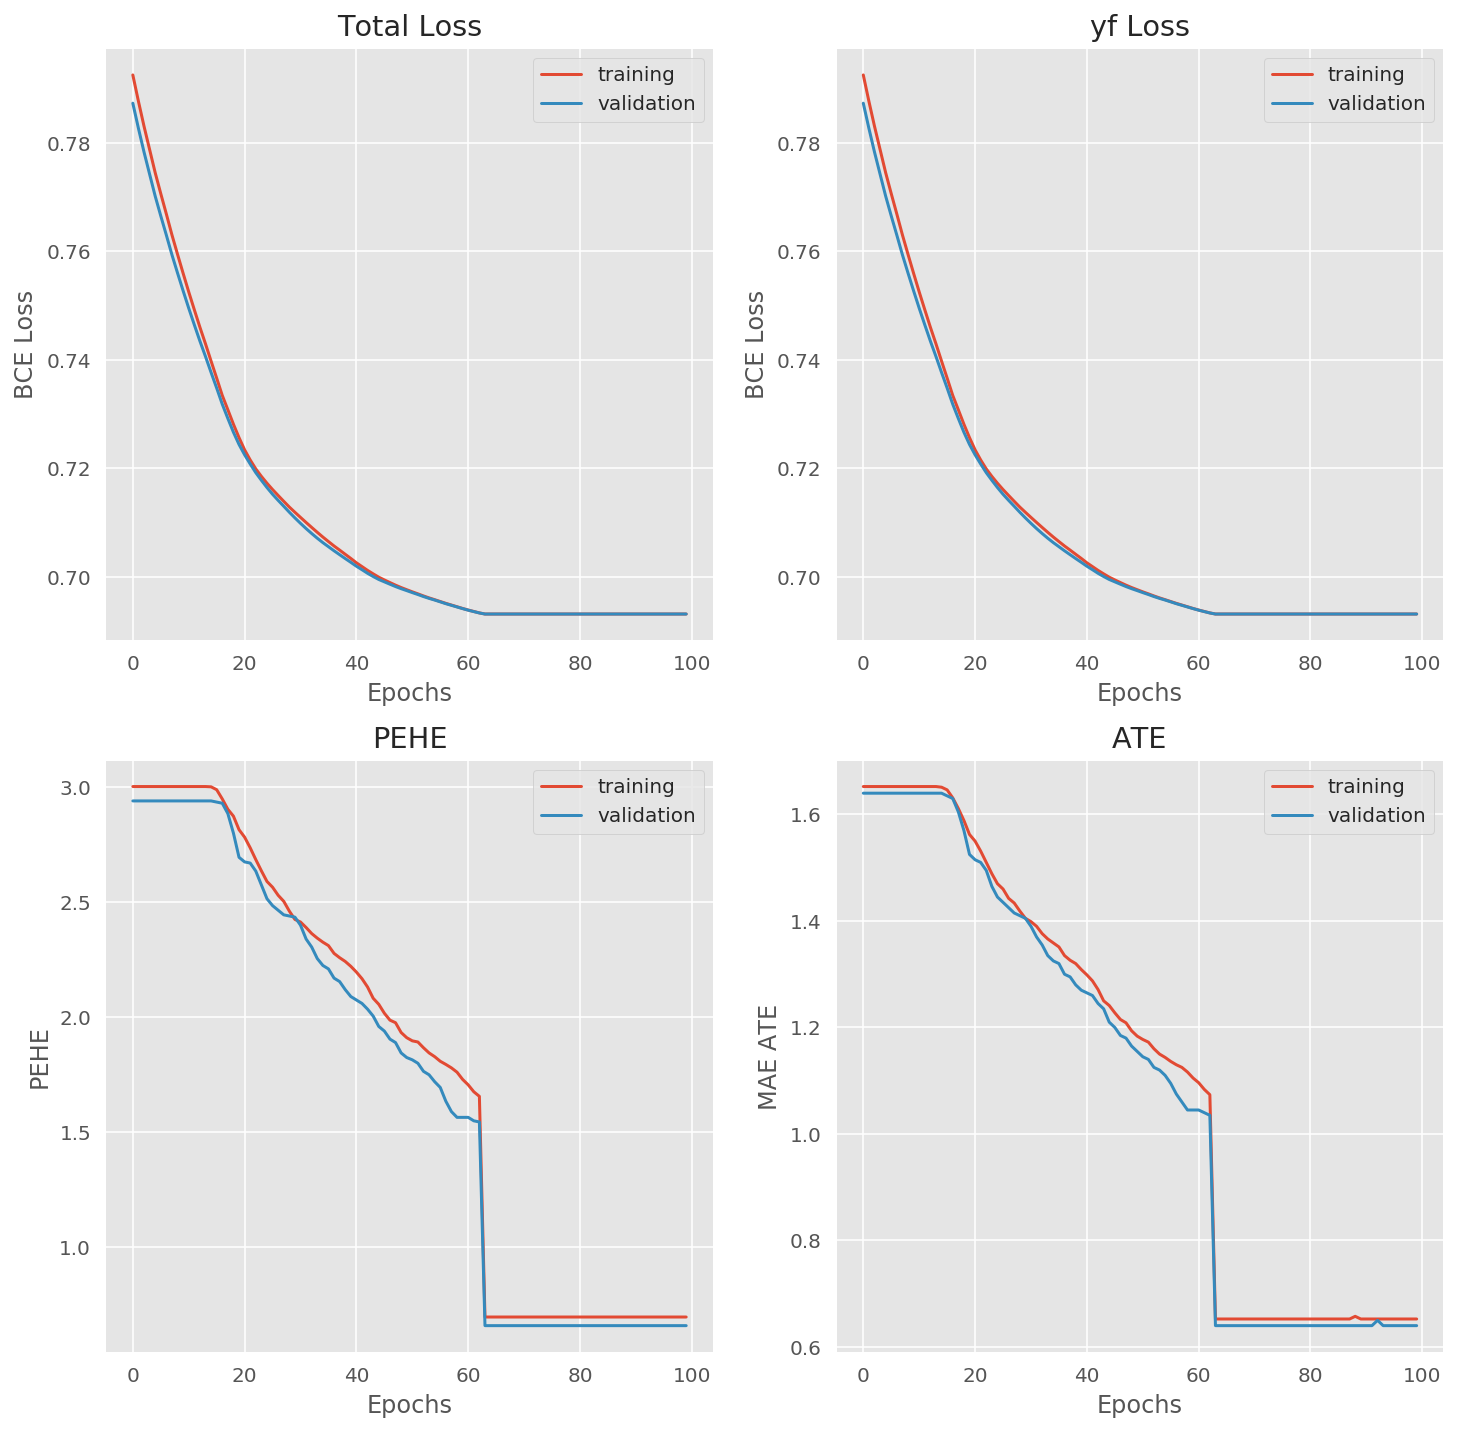

In [17]:
def run_tarnet(num_epochs, lr, train_loader, test_loader):
    model = TARNet(1, activation=nn.ReLU(), device=device)
    optimizer = Adam(model.parameters(), lr=lr)
    yf_loss = nn.BCEWithLogitsLoss(reduction='mean')

    def _prepare_batch(batch):
        x = batch['X'].to(device)
        t = batch['t'].to(device)
        yf = batch['yf'].to(device)
        return x, t, yf

    def process_function(engine, batch):
        optimizer.zero_grad()
        model.train()
        x, t, yf = _prepare_batch(batch)
        y0_pred, y1_pred, phi_x = model(x)
        yf_pred = torch.where(t == 0, y0_pred, y1_pred)
        
        loss_factual = yf_loss(yf_pred, yf)

        tr_loss = loss_factual # + TODO Desc loss
        tr_loss.backward()
        optimizer.step()

        return (
            loss_factual.item(),
            tr_loss.item()
        )

    def evaluate_function(engine, batch):
        model.eval()
        with torch.no_grad():
            x, t, yf = _prepare_batch(batch)
            y0_pred, y1_pred, phi_x = model(x)
            yf_pred = torch.where(t == 0, y0_pred, y1_pred)
            #import pdb; pdb.set_trace()
            return (
                y0_pred, batch['y0'],
                y1_pred, batch['y1'],
                yf_pred, yf
            )

    trainer = Engine(process_function)
    evaluator = Engine(evaluate_function)
    train_evaluator = Engine(evaluate_function)
    pbar = ProgressBar(persist=False)

    ignite_metrics.RunningAverage(output_transform=lambda x: x[0])\
        .attach(trainer, 'tr_factual_loss')
    # pbar.attach(trainer, ['tr_factual_loss'])

    # eval_metrics
    eval_metrics = {
        "factual_loss": ignite_metrics.Loss(
            yf_loss, output_transform=lambda x: [x[4], x[5]]),
        # PEHE is defined as ((y1 - y0)_true - (y1 - y0)_pred)**2 .mean() for each patient
        "pehe": ignite_metrics.Average(
           output_transform=lambda x: ((x[3] - x[1]) - (
               torch.round(torch.sigmoid(x[2])) - torch.round(torch.sigmoid(x[0])))).pow(2).mean()),
        "mae_ate": ignite_metrics.Average(
           output_transform=lambda x: ((x[3] - x[1]).mean() - (
               torch.round(torch.sigmoid(x[2])) - torch.round(torch.sigmoid(x[0])).mean())).abs().mean()),
        "ite_true": ignite_metrics.Average(
           output_transform=lambda x: (x[3] - x[1]) * x[3].shape[0]), # we dont want average
        "ite_pred": ignite_metrics.Average(
           output_transform=lambda x:
                x[2].shape[0] * (torch.round(torch.sigmoid(x[2])) - torch.round(torch.sigmoid(x[0])))),
        "factual_acc": ignite_metrics.Accuracy(
            output_transform=lambda x: [torch.round(torch.sigmoid(x[4])), x[5]]),
        "factual_precision": ignite_metrics.Precision(
            output_transform=lambda x: [torch.round(torch.sigmoid(x[4])), x[5]]),
        "factual_recall": ignite_metrics.Recall(
            output_transform=lambda x: [torch.round(torch.sigmoid(x[4])), x[5]]),
    }
    # eval_metrics['pehe'] = (eval_metrics['ite_true'] - eval_metrics['ite_pred']).pow(2).mean()
    # eval_metrics['mae_ate'] = (eval_metrics['ite_true'].mean() - eval_metrics['ite_pred'].mean()).abs().mean()
    eval_metrics['total_loss'] = eval_metrics['factual_loss']

    for eval_engine in [evaluator, train_evaluator]:
        for name, metric in eval_metrics.items():
            metric.attach(eval_engine, name)

    tr_metrics_history = {k: [] for k in eval_metrics.keys()}
    val_metrics_history = {k: [] for k in eval_metrics.keys()}

    @trainer.on(Events.EPOCH_COMPLETED)
    def run_validation(engine):
        if device == "cuda":
            torch.cuda.synchronize()
        train_evaluator.run(train_loader)
        evaluator.run(test_loader)

    def handle_logs(evaluator, trainer, mode, metrics_history):
        metrics = evaluator.state.metrics
        factual_loss = metrics['factual_loss']
        avg_loss = metrics['total_loss']
        # import pdb; pdb.set_trace()
        for key, value in evaluator.state.metrics.items():
            metrics_history[key].append(value)

        print_str = f"{mode} Results - Epoch {trainer.state.epoch} - "+\
                    f"Avg yf loss: {factual_loss:.4f} " +\
                    f"Avg loss: {avg_loss:.4f} " +\
                    f"PEHE: {metrics['pehe']:.4f} " +\
                    f"MAE ATE: {metrics['mae_ate']:.4f} " +\
                    f"acc: {metrics['factual_acc']:.4f} " +\
                    f"true ITE: {metrics['ite_true'].mean():.4f} " +\
                    f"pred ITE: {metrics['ite_pred'].mean():.4f} " +\
                    f"precision: {metrics['factual_precision']:.4f}."
                    # f"recall: {metrics['factual_recall']:.4f} " +\
                    # f"precision: {metrics['factual_precision']:.4f}."

        print(print_str)

    train_evaluator.add_event_handler(
        Events.COMPLETED,
        handle_logs,
        trainer,
        'Training',
        tr_metrics_history
    )
    evaluator.add_event_handler(
        Events.COMPLETED,
        handle_logs,
        trainer,
        'Validate',
        val_metrics_history
    )

    trainer.run(train_loader, max_epochs=num_epochs)

    # Plot training curve
    with plt.style.context(PLOT_STYLE):
        fig, ax = plt.subplots(2, 2, figsize=(12, 12))
        sns.lineplot(x=range(num_epochs), y=tr_metrics_history['total_loss'], ax=ax[0, 0], err_style=None, label='training')
        sns.lineplot(x=range(num_epochs), y=val_metrics_history['total_loss'], ax=ax[0, 0], err_style=None, label='validation')
        ax[0, 0].set_xlabel('Epochs')
        ax[0, 0].set_ylabel('BCE Loss')
        ax[0, 0].set_title('Total Loss')

        sns.lineplot(x=range(num_epochs), y=tr_metrics_history['factual_loss'], ax=ax[0, 1], err_style=None, label='training')
        sns.lineplot(x=range(num_epochs), y=val_metrics_history['factual_loss'], ax=ax[0, 1], err_style=None, label='validation')
        ax[0, 1].set_xlabel('Epochs')
        ax[0, 1].set_ylabel('BCE Loss')
        ax[0, 1].set_title('yf Loss')

        sns.lineplot(x=range(num_epochs), y=tr_metrics_history['pehe'], ax=ax[1, 0], err_style=None, label='training')
        sns.lineplot(x=range(num_epochs), y=val_metrics_history['pehe'], ax=ax[1, 0], err_style=None, label='validation')
        ax[1, 0].set_xlabel('Epochs')
        ax[1, 0].set_ylabel('PEHE')
        ax[1, 0].set_title('PEHE')

        sns.lineplot(x=range(num_epochs), y=tr_metrics_history['mae_ate'], ax=ax[1, 1], err_style=None, label='training')
        sns.lineplot(x=range(num_epochs), y=val_metrics_history['mae_ate'], ax=ax[1, 1], err_style=None, label='validation')
        ax[1, 1].set_xlabel('Epochs')
        ax[1, 1].set_ylabel('MAE ATE')
        ax[1, 1].set_title('ATE')

run_tarnet(100, 1e-4, train_loader, test_loader)

/home/severi/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Training Results - Epoch 1 - PEHE: 0.6261 MAE ATE: -0.5954 y_reconc_loss: 3.1526 x_reconc_loss: 28.2259 t_reconc_loss: 5.2052 kld_loss: 0.2604 t_aux_loss: 5.5603 y_aux_loss: 3.0325 total_loss: 45.4369 
Validate Results - Epoch 1 - PEHE: 0.5908 MAE ATE: -0.5830 y_reconc_loss: 2.7943 x_reconc_loss: 28.3073 t_reconc_loss: 5.3148 kld_loss: 0.2593 t_aux_loss: 5.5631 y_aux_loss: 2.8292 total_loss: 45.0681 
Training Results - Epoch 2 - PEHE: 0.6277 MAE ATE: -0.5967 y_reconc_loss: 3.0393 x_reconc_loss: 25.2802 t_reconc_loss: 5.2693 kld_loss: 0.3294 t_aux_loss: 5.5608 y_aux_loss: 3.0331 total_loss: 42.5120 
Validate Results - Epoch 2 - PEHE: 0.5910 MAE ATE: -0.5839 y_reconc_loss: 2.8339 x_reconc_loss: 25.3279 t_reconc_loss: 5.2764 kld_loss: 0.3298 t_aux_loss: 5.5580 y_aux_loss: 2.8370 total_loss: 42.1629 
Training Results - Epoch 3 - PEHE: 0.6268 MAE ATE: -0.5957 y_reconc_loss: 3.0344 x_reconc_loss: 24.3050 t_reconc_loss: 5.0703 kld_loss: 0.3550 t_aux_loss: 5.5501 y_aux_loss: 3.0260 total_loss:

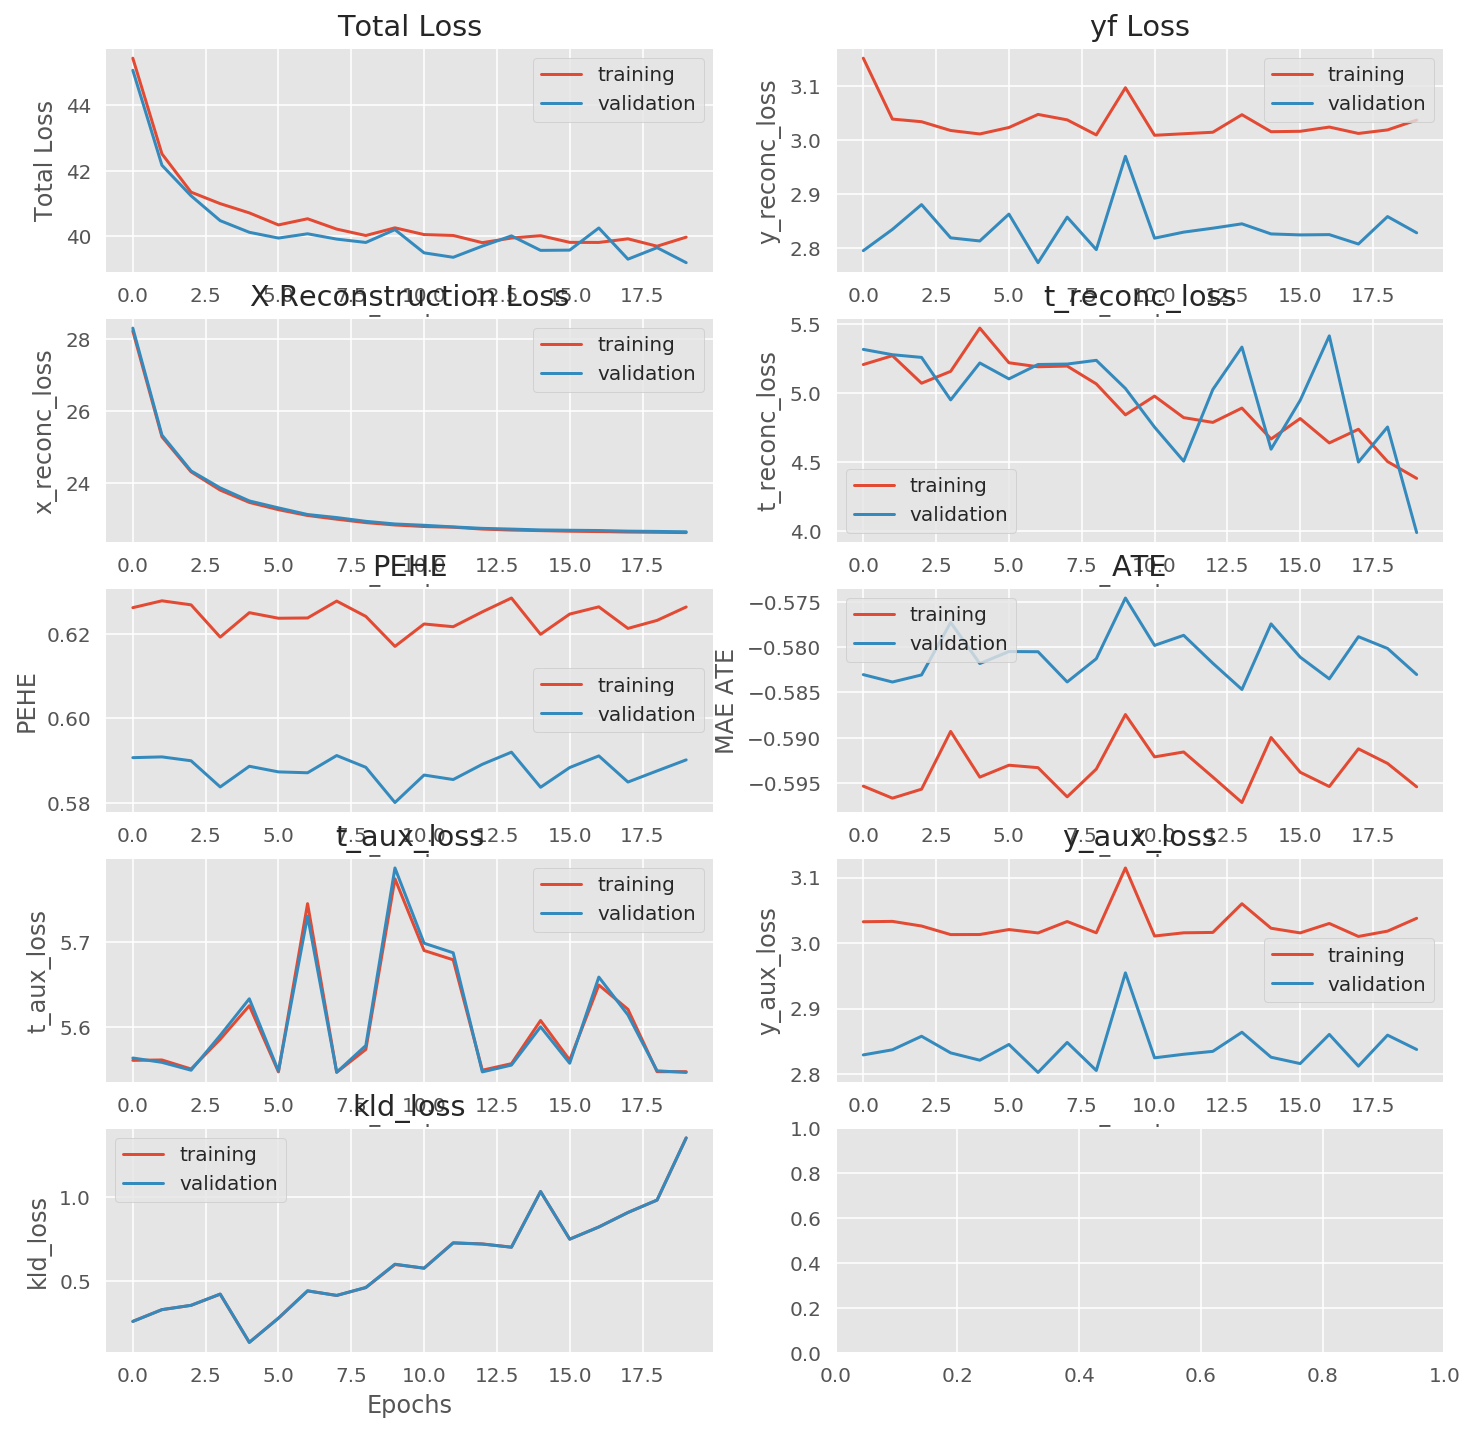

In [82]:
%autoreload 2
from models import *

def kld_loss(mu, var, kld_coef=1.):
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    #Note that the sum is over the dimensions of z as well as over the units in the batch here
    kld = -0.5 * torch.sum(1 + torch.log(var) - mu.pow(2) - var)#Need to check that this is right, especially with logvar being a var
    return kld_coef * kld

def x_reconc_loss(mean, var, x):
    return -dist.normal.Normal(mean,torch.sqrt(var)).log_prob(x).sum()

def run_cevae(num_epochs, lr, train_loader, test_loader):
    model = CEVAE(1, activation=nn.ReLU(), device=device)
    optimizer = Adam(model.parameters(), lr=lr)

    #Loss functions needed: x,t and y reconstruction losses, kld loss and t & y infer losses

    #TODO: Check that these are all ok, should maybe just create the dists and get the log_prob from them
    yf_loss_fn = nn.BCEWithLogitsLoss(reduction='sum')#t and y should in principle form one classification problem
    t_loss_fn = nn.BCEWithLogitsLoss(reduction='sum')#Sum because kld_loss assumes sum
    #x_loss_fn = nn.MSELoss(reduction='sum') <- this is either complicated expression or we use the dist library

    t_aux_loss_fn = nn.BCEWithLogitsLoss(reduction='sum')#This could be mean since it doesn't couple with the VAE
    y_aux_loss_fn = nn.BCEWithLogitsLoss(reduction='sum')

    def _prepare_batch(batch):
        x = batch['X'].to(device)
        t = batch['t'].to(device)
        yf = batch['yf'].to(device)
        if len(x.shape) == 1:#Temporary, making sure that shapes are bs x dim
            x = x[:,None]
            yf = yf[:,None]
            t = t[:,None]
        return x, t, yf

    def process_function(engine, batch):
        optimizer.zero_grad()
        model.train()
        x, t, yf = _prepare_batch(batch)
        
        if len(x.shape) == 1:
            print("Shapes in process_function: {} {} {}".format(x.shape, t.shape, y.shape))
        (z_mean, z_var, x_mean, x_var, t_logits, 
            y_logits, tinfer_logit, yinfer_logit) = model(x,t,yf)
        
        #mse_loss = reconc_loss_fn(x_reconc, x) #These will match with the new losses
        #Alternative: log(sqrt(2 pi x_var)) + (x-x_mean)/(2*x_var)
        x_loss = -dist.normal.Normal(x_mean,torch.sqrt(x_var)).log_prob(x).sum()
        t_loss = t_loss_fn(t_logits, t)#Let's hope that this is correct (first logit, then actual t)
        yf_loss = yf_loss_fn(y_logits, yf)
        kld = kld_loss(z_mean, z_var)

        # aux losses
        t_aux_loss = t_aux_loss_fn(tinfer_logit, t)
        y_aux_loss = y_aux_loss_fn(yinfer_logit, yf)

        tr_loss = x_loss + t_loss + yf_loss + kld + t_aux_loss + y_aux_loss
        tr_loss.backward()
        optimizer.step()

        return (
            yf_loss.item(),
            kld.item(),
            x_loss.item(),
            t_loss.item(),
            t_aux_loss.item(),
            y_aux_loss.item()
        )

    def evaluate_function(engine, batch):#This needs to be changed or maybe the eval_metrics?
        model.eval()
        with torch.no_grad():
            x, t, yf = _prepare_batch(batch)
            #How should the model be operated during test time? Technically were not allowed to use
            #t or yf. 
            (z_mean, z_var, x_mean, x_var, t_logits, 
                y_logits, tinfer_logit, yinfer_logit) = model(x,t,yf)#Do we need this for anything?
            
            #ITE inference
            E_y_x_do1, E_y_x_do0 = model.evaluate_batch(x)
            ITE_x = E_y_x_do1 - E_y_x_do0
            
            return {
                "E_y_x_do1":E_y_x_do1,"E_y_x_do0":E_y_x_do0,"ITE_x":ITE_x,
                "y1":batch['y1'],"y0":batch['y0'],
                "y_logits":y_logits, "yinfer_logit":yinfer_logit, "yf":yf,
                "x_mean":x_mean,"x_var":x_var,"x":x,
                "t_logits":t_logits, "tinfer_logit":tinfer_logit,"t":t,
                "z_mean":z_mean, "z_var":z_var
            }

    trainer = Engine(process_function)
    evaluator = Engine(evaluate_function)
    train_evaluator = Engine(evaluate_function)
    pbar = ProgressBar(persist=False)

    #ignite_metrics.RunningAverage(output_transform=lambda x: x[0])\
    #    .attach(trainer, 'tr_factual_loss')
    # pbar.attach(trainer, ['tr_factual_loss'])


    # eval_metrics
    eval_metrics = {
        # PEHE is defined as ((y1 - y0)_true - (y1 - y0)_pred)**2 .mean() for each patient
        "pehe": ignite_metrics.Average(
           output_transform=lambda x: (x["ITE_x"] - (x["y1"] - x["y0"])).pow(2).mean()),
        "mae_ate": ignite_metrics.Average(
           output_transform=lambda x: ((x["ITE_x"] - (x["y1"] - x["y0"])).mean())),
        "y_reconc_loss": ignite_metrics.Loss(
            yf_loss_fn, output_transform=lambda x: [x["y_logits"], x["yf"]]),
        "x_reconc_loss": ignite_metrics.Average(
            output_transform=lambda x: x_reconc_loss(x["x_mean"], x["x_var"], x["x"])),
        "kld_loss": ignite_metrics.Loss(
            kld_loss, output_transform=lambda x: [x["z_mean"], x["z_var"]]),
        "t_reconc_loss": ignite_metrics.Loss(
            t_loss_fn, output_transform=lambda x: [x["t_logits"], x["t"]]),
        "t_aux_loss": ignite_metrics.Loss(
            t_loss_fn, output_transform=lambda x: [x["tinfer_logit"], x["t"]]),
        "y_aux_loss": ignite_metrics.Loss(
            yf_loss_fn, output_transform=lambda x: [x["yinfer_logit"], x["yf"]])
        # "ite_true": ignite_metrics.Average(
        #    output_transform=lambda x: x[3] - x[1]),
        # "ite_pred": ignite_metrics.Average(
        #    output_transform=lambda x: rounded_sigmoid(x[2]) - rounded_sigmoid(x[0])),
        #"factual_acc": ignite_metrics.Accuracy(
        #    output_transform=lambda x: [rounded_sigmoid(x[4]), rounded_sigmoid(x[5])]),
        #"factual_precision": ignite_metrics.Precision(
        #    output_transform=lambda x: [rounded_sigmoid(x[4]), rounded_sigmoid(x[5])]),
        #"factual_recall": ignite_metrics.Recall(
        #    output_transform=lambda x: [rounded_sigmoid(x[4]), rounded_sigmoid(x[5])]),
    # eval_metrics['pehe'] = (eval_metrics['ite_true'] - eval_metrics['ite_pred']).pow(2).mean()
    # eval_metrics['mae_ate'] = (eval_metrics['ite_true'].mean() - eval_metrics['ite_pred'].mean()).abs().mean()
    }
    
    eval_metrics['total_loss'] = (eval_metrics["y_reconc_loss"] + 
                                  eval_metrics["x_reconc_loss"] + 
                                  eval_metrics["t_reconc_loss"] + 
                                  eval_metrics["kld_loss"] + 
                                  eval_metrics["t_aux_loss"] + 
                                  eval_metrics["y_aux_loss"])

    for eval_engine in [evaluator, train_evaluator]:#What is this about? Something to do with the continuous tracking of losses?
        for name, metric in eval_metrics.items():
            metric.attach(eval_engine, name)

    tr_metrics_history = {k: [] for k in eval_metrics.keys()}
    val_metrics_history = {k: [] for k in eval_metrics.keys()}

    @trainer.on(Events.EPOCH_COMPLETED)
    def run_validation(engine):
        if device == "cuda":
            torch.cuda.synchronize()
        train_evaluator.run(train_loader)
        evaluator.run(test_loader)

    def handle_logs(evaluator, trainer, mode, metrics_history):
        metrics = evaluator.state.metrics
        # import pdb; pdb.set_trace()
        for key, value in evaluator.state.metrics.items():
            metrics_history[key].append(value)

        print_str = f"{mode} Results - Epoch {trainer.state.epoch} - "+\
                    f"PEHE: {metrics['pehe']:.4f} " +\
                    f"MAE ATE: {metrics['mae_ate']:.4f} " +\
                    f"y_reconc_loss: {metrics['y_reconc_loss']:.4f} " +\
                    f"x_reconc_loss: {metrics['x_reconc_loss']:.4f} " +\
                    f"t_reconc_loss: {metrics['t_reconc_loss']:.4f} " +\
                    f"kld_loss: {metrics['kld_loss']:.4f} " +\
                    f"t_aux_loss: {metrics['t_aux_loss']:.4f} " +\
                    f"y_aux_loss: {metrics['y_aux_loss']:.4f} " +\
                    f"total_loss: {metrics['total_loss']:.4f} "
                    #f"precision: {metrics['factual_precision']:.4f}."
                    # f"true ITE: {metrics['ite_true'].sum():.4f} " +\
                    # f"pred ITE: {metrics['ite_pred'].sum():.4f} " +\
                    # f"acc: {metrics['factual_acc']:.4f} "
                    # f"recall: {metrics['factual_recall']:.4f} " +\
                    # f"precision: {metrics['factual_precision']:.4f}."
        print(print_str)

    train_evaluator.add_event_handler(
        Events.COMPLETED,
        handle_logs,
        trainer,
        'Training',
        tr_metrics_history
    )
    evaluator.add_event_handler(
        Events.COMPLETED,
        handle_logs,
        trainer,
        'Validate',
        val_metrics_history
    )

    trainer.run(train_loader, max_epochs=num_epochs)

    # Plot training curve
    with plt.style.context(PLOT_STYLE):
        fig, ax = plt.subplots(5, 2, figsize=(12, 12))
        sns.lineplot(x=range(num_epochs), y=tr_metrics_history['total_loss'], ax=ax[0, 0], err_style=None, label='training')
        sns.lineplot(x=range(num_epochs), y=val_metrics_history['total_loss'], ax=ax[0, 0], err_style=None, label='validation')
        ax[0, 0].set_xlabel('Epochs')
        ax[0, 0].set_ylabel('Total Loss')
        ax[0, 0].set_title('Total Loss')

        sns.lineplot(x=range(num_epochs), y=tr_metrics_history['y_reconc_loss'], ax=ax[0, 1], err_style=None, label='training')
        sns.lineplot(x=range(num_epochs), y=val_metrics_history['y_reconc_loss'], ax=ax[0, 1], err_style=None, label='validation')
        ax[0, 1].set_xlabel('Epochs')
        ax[0, 1].set_ylabel('y_reconc_loss')
        ax[0, 1].set_title('yf Loss')

        sns.lineplot(x=range(num_epochs), y=tr_metrics_history['x_reconc_loss'], ax=ax[1, 0], err_style=None, label='training')
        sns.lineplot(x=range(num_epochs), y=val_metrics_history['x_reconc_loss'], ax=ax[1, 0], err_style=None, label='validation')
        ax[1, 0].set_xlabel('Epochs')
        ax[1, 0].set_ylabel('x_reconc_loss')
        ax[1, 0].set_title('X Reconstruction Loss')

        sns.lineplot(x=range(num_epochs), y=tr_metrics_history['t_reconc_loss'], ax=ax[1, 1], err_style=None, label='training')
        sns.lineplot(x=range(num_epochs), y=val_metrics_history['t_reconc_loss'], ax=ax[1, 1], err_style=None, label='validation')
        ax[1, 1].set_xlabel('Epochs')
        ax[1, 1].set_ylabel('t_reconc_loss')
        ax[1, 1].set_title('t_reconc_loss')

        #fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        sns.lineplot(x=range(num_epochs), y=tr_metrics_history['pehe'], ax=ax[2, 0], err_style=None, label='training')
        sns.lineplot(x=range(num_epochs), y=val_metrics_history['pehe'], ax=ax[2, 0], err_style=None, label='validation')
        ax[2, 0].set_xlabel('Epochs')
        ax[2, 0].set_ylabel('PEHE')
        ax[2, 0].set_title('PEHE')

        sns.lineplot(x=range(num_epochs), y=tr_metrics_history['mae_ate'], ax=ax[2, 1], err_style=None, label='training')
        sns.lineplot(x=range(num_epochs), y=val_metrics_history['mae_ate'], ax=ax[2, 1], err_style=None, label='validation')
        ax[2, 1].set_xlabel('Epochs')
        ax[2, 1].set_ylabel('MAE ATE')
        ax[2, 1].set_title('ATE')
        
        sns.lineplot(x=range(num_epochs), y=tr_metrics_history['t_aux_loss'], ax=ax[3, 0], err_style=None, label='training')
        sns.lineplot(x=range(num_epochs), y=val_metrics_history['t_aux_loss'], ax=ax[3, 0], err_style=None, label='validation')
        ax[3, 0].set_xlabel('Epochs')
        ax[3, 0].set_ylabel('t_aux_loss')
        ax[3, 0].set_title('t_aux_loss')
        
        sns.lineplot(x=range(num_epochs), y=tr_metrics_history['y_aux_loss'], ax=ax[3, 1], err_style=None, label='training')
        sns.lineplot(x=range(num_epochs), y=val_metrics_history['y_aux_loss'], ax=ax[3, 1], err_style=None, label='validation')
        ax[3, 1].set_xlabel('Epochs')
        ax[3, 1].set_ylabel('y_aux_loss')
        ax[3, 1].set_title('y_aux_loss')
        
        sns.lineplot(x=range(num_epochs), y=tr_metrics_history['kld_loss'], ax=ax[4, 0], err_style=None, label='training')
        sns.lineplot(x=range(num_epochs), y=val_metrics_history['kld_loss'], ax=ax[4, 0], err_style=None, label='validation')
        ax[4, 0].set_xlabel('Epochs')
        ax[4, 0].set_ylabel('kld_loss')
        ax[4, 0].set_title('kld_loss')
        

run_cevae(20, 3e-2, train_loader, test_loader)

In [31]:
%autoreload 2
from models import CEVAE
CEVAE(1).asd()

asdhoi
